# Feasibility and Prototype

### For this second attempt, I will be using a new dataset, one that is clean and i believe will be better for my model. Its still the same idea though, the dataset contains picutres of clean and dirty beaches.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive (3).zip to archive (3).zip


In [3]:
import zipfile

zip_filename = "archive (3).zip"

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("beach_waste")

os.listdir("beach_waste")

['Plastic on Sand']

## Data Exploration

In [4]:
base_path = "beach_waste/Plastic on Sand"
class_names = os.listdir(base_path)

for class_name in class_names:
    class_folder = os.path.join(base_path, class_name)
    num_images = len(os.listdir(class_folder))
    print(f"{class_name}: {num_images} images")

Clean: 76 images
Dirt: 76 images


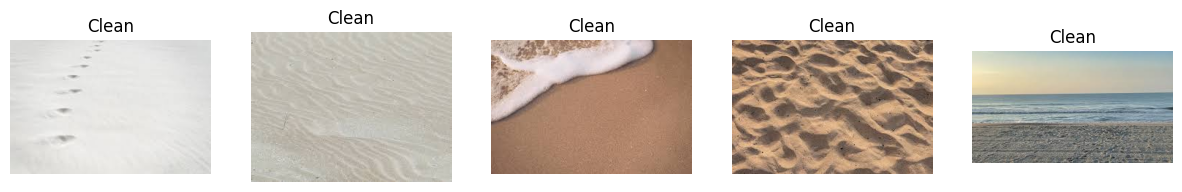

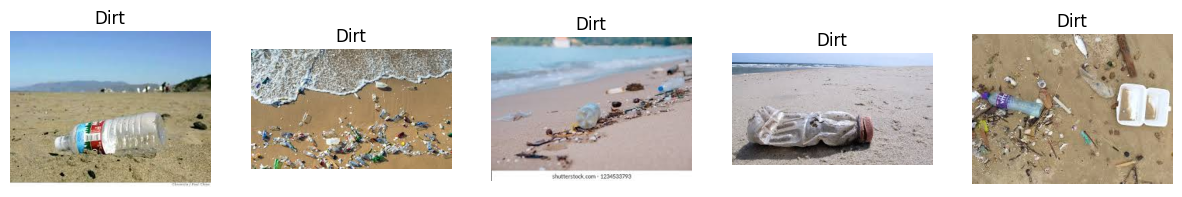

In [5]:
import matplotlib.image as mpimg
import random

def show_images(class_name, num_images=5):
    folder_path = os.path.join(base_path, class_name)
    images = os.listdir(folder_path)
    sample_images = random.sample(images, num_images)

    plt.figure(figsize=(15, 5))
    for i, img_name in enumerate(sample_images):
        img_path = os.path.join(folder_path, img_name)
        img = mpimg.imread(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

show_images('Clean')
show_images('Dirt')

## Normalizing pixel values and applying augmentation

In [6]:
# fefine paths
base_dir = "beach_waste/Plastic on Sand"
image_size = (224, 224)
batch_size = 16

# data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% for validation
)

# no augmentation for validation, just rescaling
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# training generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# validation generator
val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=False
)

Found 122 images belonging to 2 classes.
Found 30 images belonging to 2 classes.


## MobileNetV2 Model

#### What exactly am i doing?

*   freezing the base (it was pretrained on imagenet)
*   adding a new classification head
*   binary output (either waste or not_waste)

In [7]:
# base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze the convolutional base

# custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
output = Dense(1, activation='sigmoid')(x)  # binary output

model = Model(inputs=base_model.input, outputs=output)

# Compiling model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,340,033 (8.93 MB)

 Trainable params: 82,049 (320.50 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# define callbacks
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

# train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 676ms/step - accuracy: 0.5121 - loss: 0.6957

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5117 - loss: 0.6974 - val_accuracy: 0.5333 - val_loss: 0.6380
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 864ms/step - accuracy: 0.6104 - loss: 0.6140

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6163 - loss: 0.6097 - val_accuracy: 0.6000 - val_loss: 0.5814
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.6690 - loss: 0.5578

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6748 - loss: 0.5554 - val_accuracy: 0.7000 - val_loss: 0.5398
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 668ms/step - accuracy: 0.8719 - loss: 0.4172

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 899ms/step - accuracy: 0.8679 - loss: 0.4183 - val_accuracy: 0.7333 - val_loss: 0.4961
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 931ms/step - accuracy: 0.9109 - loss: 0.3853

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.9053 - loss: 0.3867 - val_accuracy: 0.7667 - val_loss: 0.4585
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 650ms/step - accuracy: 0.9125 - loss: 0.3614

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9131 - loss: 0.3600 - val_accuracy: 0.8000 - val_loss: 0.4184
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.9049 - loss: 0.3340

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 848ms/step - accuracy: 0.9091 - loss: 0.3297 - val_accuracy: 0.8000 - val_loss: 0.3897
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.9075 - loss: 0.2901

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9105 - loss: 0.2888 - val_accuracy: 0.8667 - val_loss: 0.3584
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.8946 - loss: 0.2916

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 853ms/step - accuracy: 0.8990 - loss: 0.2875 - val_accuracy: 0.9333 - val_loss: 0.3357
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - accuracy: 0.9576 - loss: 0.2492

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9559 - loss: 0.2489 - val_accuracy: 0.8667 - val_loss: 0.3205
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 628ms/step - accuracy: 0.9533 - loss: 0.2266

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 878ms/step - accuracy: 0.9539 - loss: 0.2249 - val_accuracy: 0.9000 - val_loss: 0.3018
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 695ms/step - accuracy: 0.9751 - loss: 0.1945

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 890ms/step - accuracy: 0.9752 - loss: 0.1945 - val_accuracy: 0.9333 - val_loss: 0.2798
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 643ms/step - accuracy: 1.0000 - loss: 0.1552

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 843ms/step - accuracy: 1.0000 - loss: 0.1543 - val_accuracy: 0.9667 - val_loss: 0.2563
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.9757 - loss: 0.1675

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9757 - loss: 0.1679 - val_accuracy: 0.9667 - val_loss: 0.2357
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.9802 - loss: 0.1392

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 899ms/step - accuracy: 0.9796 - loss: 0.1397 - val_accuracy: 0.9667 - val_loss: 0.2348
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.9848 - loss: 0.1206

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9856 - loss: 0.1213 - val_accuracy: 0.9333 - val_loss: 0.2321
Epoch 17/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.9838 - loss: 0.1336

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9829 - loss: 0.1337 - val_accuracy: 0.9667 - val_loss: 0.2176
Epoch 18/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 642ms/step - accuracy: 0.9944 - loss: 0.0973

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 840ms/step - accuracy: 0.9923 - loss: 0.0993 - val_accuracy: 0.9667 - val_loss: 0.2036
Epoch 19/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 835ms/step - accuracy: 0.9978 - loss: 0.1052

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.9971 - loss: 0.1067 - val_accuracy: 0.9667 - val_loss: 0.1968
Epoch 20/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 654ms/step - accuracy: 0.9968 - loss: 0.0987

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 861ms/step - accuracy: 0.9953 - loss: 0.1011 - val_accuracy: 0.9667 - val_loss: 0.1889


## Accuracy and Loss

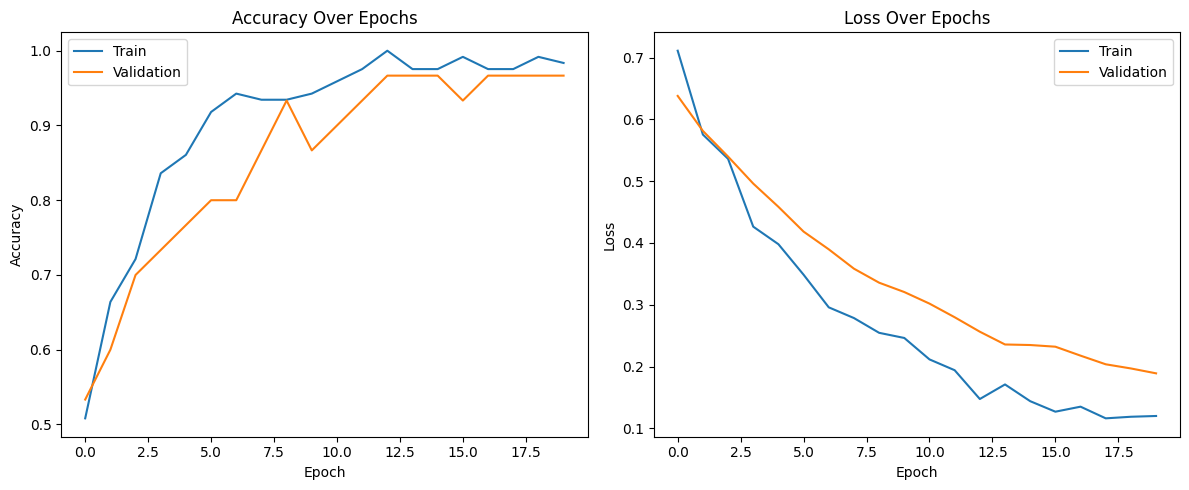

In [9]:
plt.figure(figsize=(12, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



**Accuracy Over Epochs:** This graph shows how well the model predicts correctly during training vs validation. Validation accuracy peaked arounf 97%, which means the model generalized well and wasnt just memorizing the data.

**Loss Over Epochs:** This grapgs shows how "wrong" the models predictions are. Both training and validation loss are consistently decreasing, which is good. There is a smooth curve with no sharp jumps, which equates to stable training.

**Overall, the graphs shows that the model is learning effectively and there is no clear sign of over or under fitting.**

2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 5s/step
Classification Report:
              precision    recall  f1-score   support

       Clean       0.94      1.00      0.97        15
        Dirt       1.00      0.93      0.97        15

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



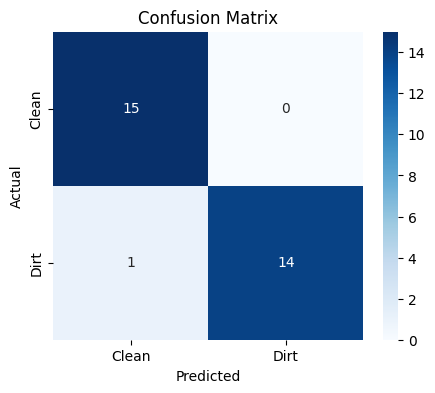

In [10]:
# predict on validation data
val_generator.reset()
preds = model.predict(val_generator)
y_pred = (preds > 0.5).astype("int32").flatten()
y_true = val_generator.classes

# report
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices, yticklabels=val_generator.class_indices)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### Overally we have 97% accuracy which is great. The confusion matrix shows the only mistake the model made, which was mislabelling 1 dirt image as clean.

### Overall the model is behaving great. Lets play around with dropout and dense layers to see how much better we can get.

In [11]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

In [13]:
# Load base MobileNetV2
base_model_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_v2.trainable = False

# adding new pieces
x = base_model_v2.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# new model
model_v2 = Model(inputs=base_model_v2.input, outputs=output)

model_v2.compile(optimizer=Adam(learning_rate=0.0001),
                 loss='binary_crossentropy',
                 metrics=['accuracy'])


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks_v2 = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model_v2.h5', save_best_only=True)
]

history_v2 = model_v2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks_v2
)

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 919ms/step - accuracy: 0.4675 - loss: 4.3709

8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4702 - loss: 4.3626 - val_accuracy: 0.5000 - val_loss: 3.8963
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 923ms/step - accuracy: 0.4984 - loss: 4.0938

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5059 - loss: 4.0805 - val_accuracy: 0.5000 - val_loss: 3.8282
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.5207 - loss: 3.9739

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5230 - loss: 3.9701 - val_accuracy: 0.6000 - val_loss: 3.7749
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 707ms/step - accuracy: 0.5593 - loss: 3.8806

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 935ms/step - accuracy: 0.5636 - loss: 3.8771 - val_accuracy: 0.7000 - val_loss: 3.7265
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 916ms/step - accuracy: 0.5314 - loss: 3.8547

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5343 - loss: 3.8536 - val_accuracy: 0.7333 - val_loss: 3.6913
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 715ms/step - accuracy: 0.6120 - loss: 3.8388

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 976ms/step - accuracy: 0.6114 - loss: 3.8341 - val_accuracy: 0.7333 - val_loss: 3.6557
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 767ms/step - accuracy: 0.5727 - loss: 3.9460

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5692 - loss: 3.9440 - val_accuracy: 0.7667 - val_loss: 3.6186
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 904ms/step - accuracy: 0.5878 - loss: 3.7737

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.5908 - loss: 3.7689 - val_accuracy: 0.7667 - val_loss: 3.5902
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.7187 - loss: 3.6276

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 939ms/step - accuracy: 0.7144 - loss: 3.6325 - val_accuracy: 0.8000 - val_loss: 3.5591
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.6965 - loss: 3.5981

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6983 - loss: 3.5981 - val_accuracy: 0.8333 - val_loss: 3.5253
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - accuracy: 0.6736 - loss: 3.5932

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6725 - loss: 3.5951 - val_accuracy: 0.8667 - val_loss: 3.4975
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - accuracy: 0.7587 - loss: 3.4841

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.7527 - loss: 3.4922 - val_accuracy: 0.8667 - val_loss: 3.4682
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.7818 - loss: 3.4953

8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.7814 - loss: 3.4932 - val_accuracy: 0.8667 - val_loss: 3.4406
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 921ms/step - accuracy: 0.7994 - loss: 3.4304

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8017 - loss: 3.4281 - val_accuracy: 0.8667 - val_loss: 3.4093
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.7478 - loss: 3.4771

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.7531 - loss: 3.4729 - val_accuracy: 0.9000 - val_loss: 3.3784
Epoch 16/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7295 - loss: 3.4998

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 972ms/step - accuracy: 0.7322 - loss: 3.4937 - val_accuracy: 0.9000 - val_loss: 3.3471
Epoch 17/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 934ms/step - accuracy: 0.7198 - loss: 3.4157

8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.7227 - loss: 3.4131 - val_accuracy: 0.9333 - val_loss: 3.3107
Epoch 18/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 870ms/step - accuracy: 0.8967 - loss: 3.2884

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8918 - loss: 3.2915 - val_accuracy: 0.9000 - val_loss: 3.2760
Epoch 19/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 720ms/step - accuracy: 0.8124 - loss: 3.3421

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 949ms/step - accuracy: 0.8151 - loss: 3.3376 - val_accuracy: 0.9333 - val_loss: 3.2410
Epoch 20/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 920ms/step - accuracy: 0.8272 - loss: 3.2605

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8273 - loss: 3.2623 - val_accuracy: 0.9333 - val_loss: 3.2078


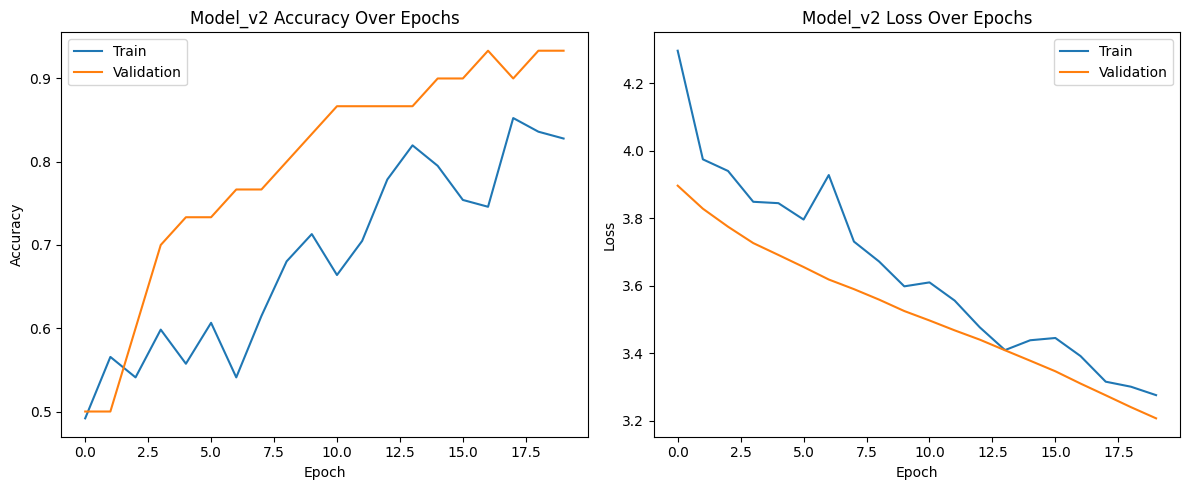

In [15]:
# plot accuracy and loss for model_v2
plt.figure(figsize=(12, 5))

# accuracy
plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Train')
plt.plot(history_v2.history['val_accuracy'], label='Validation')
plt.title('Model_v2 Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# loss
plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Train')
plt.plot(history_v2.history['val_loss'], label='Validation')
plt.title('Model_v2 Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### **Accuracy Over Epochs:** There are some weird things going on with this graph. The training accuracy is lower than validation accuracy for many epochs. Usually its the other way around. This could mean there is over-regularization going on. My dropout and dense layers could be supressing learning too much.

### **Loss Over Epochs:** In this graph, loss values are very high. The model is getting labels right but confidence is low.


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step
Classification Report (model_v2):
              precision    recall  f1-score   support

       Clean       1.00      0.87      0.93        15
        Dirt       0.88      1.00      0.94        15

    accuracy                           0.93        30
   macro avg       0.94      0.93      0.93        30
weighted avg       0.94      0.93      0.93        30



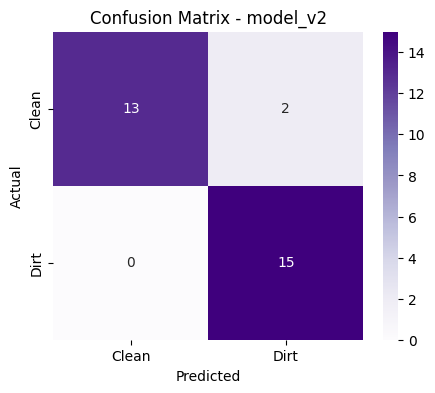

In [16]:
# predict labels
val_generator.reset()
preds_v2 = model_v2.predict(val_generator)
y_pred_v2 = (preds_v2 > 0.5).astype("int32").flatten()
y_true_v2 = val_generator.classes

# classification report
print("Classification Report (model_v2):")
print(classification_report(y_true_v2, y_pred_v2, target_names=val_generator.class_indices))

# confusion matrix
cm_v2 = confusion_matrix(y_true_v2, y_pred_v2)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_v2, annot=True, fmt='d', cmap='Purples',
            xticklabels=val_generator.class_indices,
            yticklabels=val_generator.class_indices)
plt.title('Confusion Matrix - model_v2')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### This model is perfect at catching dirty beaches. It slightly overpredicts dirtiness though.

## Overall, my first model was better

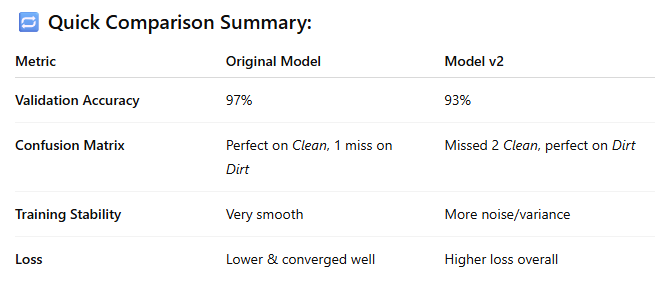

